# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
import os

# Settings
DATA_DIR = 'CIFAR'
VALIDATION_SIZE = 0.2 # Size of the validation dataset as a percentage of total data.
RANDOM_STATE = 13
CHECKPOINT_FILEPATH = 'checkpoint_CIFAR10.pth'

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
## YOUR CODE HERE ##

# Download dataset only for mean and std calculations.
# traindata =  torchvision.datasets.CIFAR10('./data/train_untransformed', 
#                                           download=True, 
#                                           train=True, 
#                                           transform=transforms.ToTensor())
# train_images = torch.stack([image for image, _ in traindata], dim=3)
# mean, std = train_images.view(3, -1).mean(dim=1), train_images.view(3, -1).std(dim=1)

# Use image mean and standard deviations for transformations.
# train_transform = transforms.Compose([transforms.RandomRotation(45),
#                                      transforms.RandomHorizontalFlip(),
#                                      transforms.ToTensor(),
#                                      transforms.Normalize(mean, 
#                                                           std)])
# test_transform = transforms.Compose([transforms.ToTensor(),
#                                      transforms.Normalize(mean, 
#                                                           std)])


# Use recommended Normalize setting by torchvision
train_transform = transforms.Compose([transforms.RandomRotation(45),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
test_transform = transforms.Compose([transforms.RandomRotation(45),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])

# Create training set and define training dataloader
## YOUR CODE HERE ##
train_set = torchvision.datasets.CIFAR10(root='./data/train', train=True, download=True, transform=train_transform)
val_set = torchvision.datasets.CIFAR10(root='./data/val', train=True, download=True, transform=test_transform)

num_train = len(train_set)
indices = list(range(num_train))
split = int(np.floor(VALIDATION_SIZE* num_train))

np.random.seed(RANDOM_STATE)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=False, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False, sampler=val_sampler)


# Create test set and define test dataloader
## YOUR CODE HERE ##
test_set = torchvision.datasets.CIFAR10(root='./data/test', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
print("Number of train data rows:", num_train)

Number of train data rows: 50000


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


car


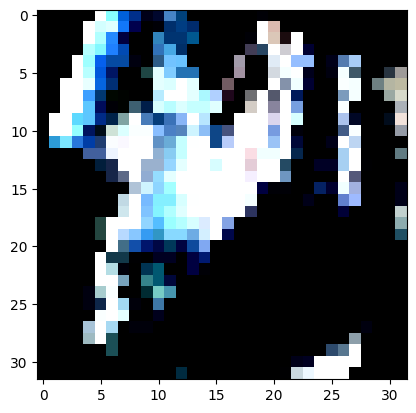

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bird


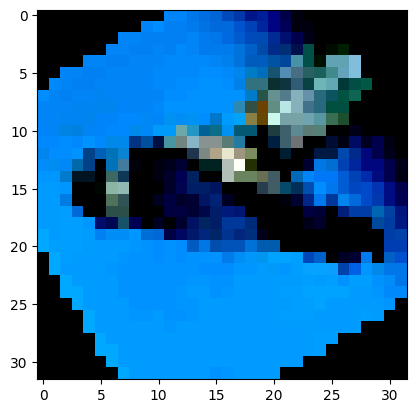

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat


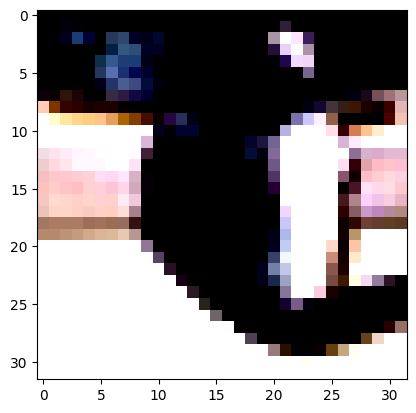

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse


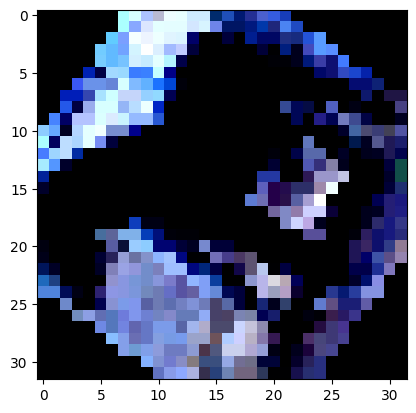

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane


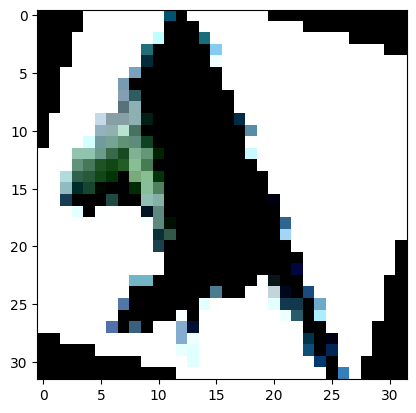

In [5]:
# Explore data
## YOUR CODE HERE ##
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [19]:
## YOUR CODE HERE ##

# Note: As it turned out, my laptop is not strong enough to run these pre-trained networks.
# model = models.resnet152(weights='ResNet152_Weights.DEFAULT')
# model = models.resnet34(weights='ResNet34_Weights.DEFAULT')
# model = models.resnet18(weights='ResNet18_Weights.DEFAULT')

# Vanilla ConvNet
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),
    nn.Flatten(),
    nn.Linear(64*8*8, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1)
)

model

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.2, inplace=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=4096, out_features=128, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=128, out_features=64, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.2, inplace=False)
  (15): Linear(in_features=64, out_features=10, bias=True)
  (16): LogSoftmax(dim=1)
)

In [20]:
# Note: As it turned out, my laptop is not strong enough to run pre-trained networks.

# Freeze parameters so we don't backprop through them
# for param in model.parameters():
#     param.requires_grad = False

# from collections import OrderedDict

# # ResNet18, ResNet34
# fc = nn.Linear(model.fc.in_features, 10)

# fc = nn.Sequential(OrderedDict([
#                    ('fc1', nn.Linear(512, 256)),
#                    ('relu', nn.ReLU()),
#                    ('fc2', nn.Linear(256, 10)),
#                    ('output', nn.LogSoftmax(dim=1))
#                    ]))

# fc = nn.Sequential(OrderedDict([
#                    ('fc1', nn.Linear(512, 256)),
#                    ('relu', nn.ReLU()),
#                    ('fc2', nn.Linear(256, 10)),
#                    ('output', nn.LogSoftmax(dim=1))
#                    ]))
# ResNet152
# fc = nn.Sequential(OrderedDict([
#                    ('fc1', nn.Linear(2048, 1024)),
#                    ('relu', nn.ReLU()),
#                    ('fc2', nn.Linear(1024, 512)),
#                    ('relu', nn.ReLU()),
#                    ('fc3', nn.Linear(512, 256)),
#                    ('relu', nn.ReLU()),
#                    ('fc4', nn.Linear(256, 10)),
#                    ('output', nn.LogSoftmax(dim=1))
#                    ]))
# model.fc = fc

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [21]:
## YOUR CODE HERE ##
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [23]:
## YOUR CODE HERE ##

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")
model.to(device)

epochs = 100
running_loss_list = []
val_loss_list = []
accuracy_list = []

start_epoch = 0

# Load checkpoint if exists
if os.path.exists(CHECKPOINT_FILEPATH):
    checkpoint = torch.load(CHECKPOINT_FILEPATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    running_loss_list = checkpoint['running_loss_list']
    accuracy_list = checkpoint['accuracy_list']
    val_loss_list = checkpoint['val_loss_list']
    model.train()

for epoch in range(start_epoch, epochs):
    running_loss = 0
    for inputs, labels in train_loader:
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        accuracy = 0
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                
                inputs, labels = inputs.to(device), labels.to(device)
    
                logps = model.forward(inputs)
                loss = criterion(logps, labels)
    
                val_loss += loss.item()
    
                # Calculate accuracy
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                        
        print(f"Epoch {epoch+1}/{epochs}.. "
                    f"Running loss: {running_loss/len(train_loader):.3f}.. "
                    f"Validation loss: {val_loss/len(val_loader):.3f}.. "
                    f"Validation accuracy: {accuracy/len(val_loader):.3f}")
        
        running_loss_list.append(round(running_loss/len(train_loader), 3))
        accuracy_list.append(round(accuracy/len(val_loader), 3))
        val_loss_list.append(round(val_loss/len(val_loader), 3))
        
        # Save model after each epoch
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'running_loss_list': running_loss_list,
            'accuracy_list': accuracy_list,
            'val_loss_list': val_loss_list
        }, CHECKPOINT_FILEPATH)
        
    model.train()

Using cuda
Epoch 44/100.. Running loss: 1.075.. Validation loss: 0.966.. Validation accuracy: 0.657
Epoch 45/100.. Running loss: 1.067.. Validation loss: 0.977.. Validation accuracy: 0.654
Epoch 46/100.. Running loss: 1.054.. Validation loss: 0.971.. Validation accuracy: 0.659
Epoch 47/100.. Running loss: 1.053.. Validation loss: 0.952.. Validation accuracy: 0.660
Epoch 48/100.. Running loss: 1.046.. Validation loss: 0.954.. Validation accuracy: 0.662
Epoch 49/100.. Running loss: 1.039.. Validation loss: 0.942.. Validation accuracy: 0.666
Epoch 50/100.. Running loss: 1.039.. Validation loss: 0.953.. Validation accuracy: 0.663
Epoch 51/100.. Running loss: 1.033.. Validation loss: 0.953.. Validation accuracy: 0.658
Epoch 52/100.. Running loss: 1.031.. Validation loss: 0.937.. Validation accuracy: 0.668
Epoch 53/100.. Running loss: 1.024.. Validation loss: 0.946.. Validation accuracy: 0.663
Epoch 54/100.. Running loss: 1.022.. Validation loss: 0.928.. Validation accuracy: 0.670
Epoch 55/1

Plot the training loss (and validation loss/accuracy, if recorded).

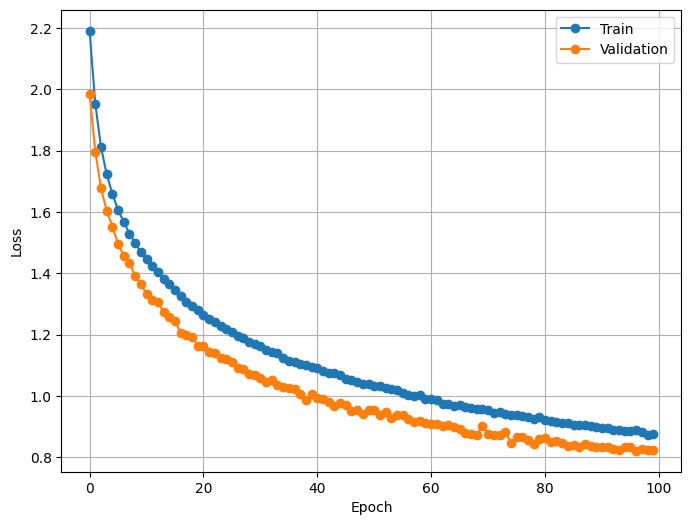

In [24]:
## YOUR CODE HERE ##
plt.figure(figsize=(8, 6))
plt.plot(running_loss_list, label='Train', marker='o')
plt.plot(val_loss_list, label='Validation', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

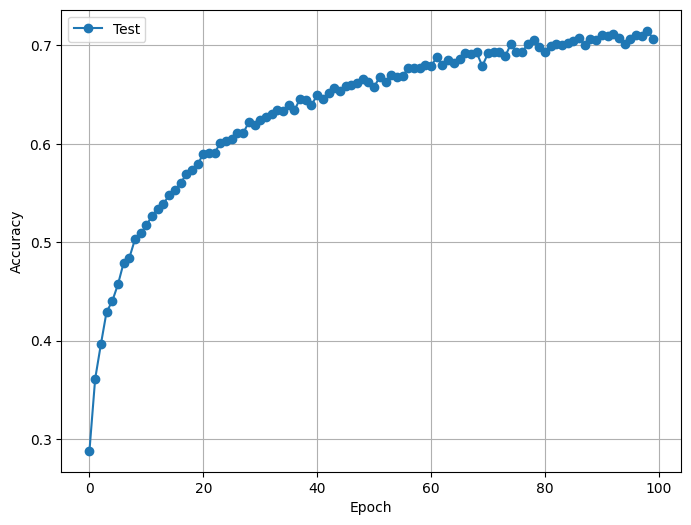

In [25]:
plt.figure(figsize=(8, 6))
plt.plot(accuracy_list, label='Test', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [26]:
## YOUR CODE HERE ##


accuracy = 0
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        logps = model.forward(inputs)
                
        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
accuracy = accuracy/len(test_loader)
print(f'Test Accuracy: {accuracy*100:.2f}%')

Test Accuracy: 70.61%


## Saving your model
Using `torch.save`, save your model for future loading.

In [27]:
## YOUR CODE HERE ##
torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'running_loss_list': running_loss_list,
    'accuracy_list': accuracy_list,
    'val_loss_list': val_loss_list
}, CHECKPOINT_FILEPATH)

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

With a simple Convolutional Network architecture and sufficient training epochs, we managed to reach 70% accuracy.

Therefore, I believe it is better to build our own classifier.

Due to hardware limitation, I was not able to use a pretrained torchvision model. As a workaround:

- I use a vanilla Convolutional Network, but increased the number of training epochs to 100.
- Since the notebook was run in multiple sessions, I added a feature to save/load the progress as we train.